In [75]:
from __future__ import print_function
import tensorflow as tf
from tensorflow.contrib import rnn
# import function from segment_EEG 
from segment_EEG import *
from data_loader import check_load_Yvonne_dataset

EEG_file_path = '/Users/Madhu/Documents/Courses/RA/EEG_data/YvonneDataSet_Exported_1.mat'
label_file =  '/Users/Madhu/Documents/Courses/RA/EEG_data/YvonneDataSet_Labels_1.mat'

EEG_channels = ['F3M2','F4M1','C3M2','C4M1','O1M2','O2M1']
EEG, sleep_stage, other_info = check_load_Yvonne_dataset(EEG_file_path, label_file, channels=EEG_channels)

# segments EEG and sleep stage vector into 30 seconds windows
#segs, sleep_stages, seg_times, seg_masks = segment_EEG(EEG,sleep_stage,30,200,start_end_remove_epoch_num=2,amplitude_thres=500, to_remove_mean=False)


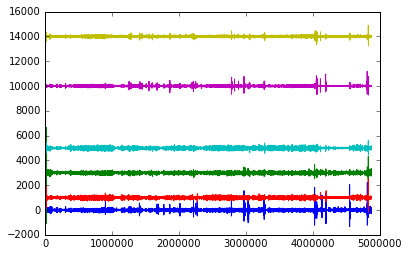

In [67]:
#print ("EEG",type(EEG)) (4872000, 6)
import matplotlib.pyplot as plt
%matplotlib inline
# plt.plot(sleep_stage)
plt.plot(EEG[:,0]) 
plt.plot(EEG[:,1]+3000) 
plt.plot(EEG[:,2]+1000)
plt.plot(EEG[:,3]+5000 )
plt.plot(EEG[:,4]+10000)
plt.plot(EEG[:,5]+14000)
# plt.plot(EEG[:,6]+30000)


In [13]:
# Parameters
learning_rate = 0.001
training_iters = 100000
batch_size = 128
display_step = 10

# Network Parameters
n_input = 28 # MNIST data input (img shape: 28*28)
n_steps = 28 # timesteps
n_hidden = 128 # hidden layer num of features
n_classes = 10 # MNIST total classes (0-9 digits)

# tf Graph input
x = tf.placeholder("float", [None, n_steps, n_input])
y = tf.placeholder("float", [None, n_classes])

# Define weights
weights = {
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes]))
}

biases = {
    'out': tf.Variable(tf.random_normal([n_classes]))
}


In [55]:
biases['out'].get_shape()

TensorShape([Dimension(10)])

In [20]:
def RNN(x, weights, biases):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, n_steps, n_input)
    # Required shape: 'n_steps' tensors list of shape (batch_size, n_input)

    # Permuting batch_size and n_steps
    x = tf.transpose(x, [1, 0, 2]) #n_steps , batch , input features
    # Reshaping to (n_steps*batch_size, n_input)
    x = tf.reshape(x, [-1, n_input])
    # Split to get a list of 'n_steps' tensors of shape (batch_size, n_input)
    x = tf.split(x, n_steps, 0)
    #x = tf.split(0, n_steps,x)

    # Define a lstm cell with tensorflow
    lstm_cell = rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)
    #lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0)

    # Get lstm cell output
    outputs, states = rnn.static_rnn(lstm_cell, x, dtype=tf.float32)
    #outputs, states = tf.nn.rnn_cell.static_rnn(lstm_cell, x, dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    return tf.matmul(outputs[-1], weights['out']) + biases['out']



In [21]:
pred = RNN(x, weights, biases)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables
init = tf.global_variables_initializer()


In [22]:
batch_x, batch_y = mnist.train.next_batch(batch_size)

In [25]:
batch_x = batch_x.reshape((batch_size, n_steps, n_input))

In [41]:
    sess = tf.Session() 
    sess.run(init)
    sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
    # Calculate batch accuracy
    acc = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})
    # Calculate batch loss
    loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
    print("Iter, Minibatch Loss= " + \
    "{:.6f}".format(loss) + ", Training Accuracy= " + \
    "{:.5f}".format(acc))



Iter, Minibatch Loss= 2.797817, Training Accuracy= 0.08594


In [50]:
#pred = RNN(batch_x, weights, biases)
k = sess.run(pred, feed_dict={x: batch_x, y: batch_y})
#tf.Print(pred,[pred])

In [54]:
k[0]

array([-0.61608422, -1.19382083,  0.16823873,  0.85100746,  0.90058351,
        0.28820345,  0.90822792,  1.32124901, -0.48871747, -1.49195373], dtype=float32)

In [76]:
# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    step = 1
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Reshape data to get 28 seq of 28 elements
        batch_x = batch_x.reshape((batch_size, n_steps, n_input))
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        if step % display_step == 0:
            # Calculate batch accuracy
            acc           = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})
            #pred_val      = sess.run(correct_pred, feed_dict={x: batch_x, y: batch_y})
    
            
            #print(pred_val)
            # Calculate batch loss
            loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
            print("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
        step += 1
    print("Optimization Finished!")

    # Calculate accuracy for 128 mnist test images
    test_len = 128
    test_data = mnist.test.images[:test_len].reshape((-1, n_steps, n_input))
    test_label = mnist.test.labels[:test_len]
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={x: test_data, y: test_label}))

Iter 1280, Minibatch Loss= 2.092655, Training Accuracy= 0.27344
Iter 2560, Minibatch Loss= 1.874824, Training Accuracy= 0.39844
Iter 3840, Minibatch Loss= 1.376874, Training Accuracy= 0.48438
Iter 5120, Minibatch Loss= 1.132361, Training Accuracy= 0.62500
Iter 6400, Minibatch Loss= 0.932221, Training Accuracy= 0.67969
Iter 7680, Minibatch Loss= 1.236949, Training Accuracy= 0.59375
Iter 8960, Minibatch Loss= 1.049973, Training Accuracy= 0.66406
Iter 10240, Minibatch Loss= 0.857208, Training Accuracy= 0.73438
Iter 11520, Minibatch Loss= 0.541492, Training Accuracy= 0.85156
Iter 12800, Minibatch Loss= 0.838951, Training Accuracy= 0.71875
Iter 14080, Minibatch Loss= 0.706109, Training Accuracy= 0.75000
Iter 15360, Minibatch Loss= 0.455755, Training Accuracy= 0.86719
Iter 16640, Minibatch Loss= 0.476670, Training Accuracy= 0.89062
Iter 17920, Minibatch Loss= 0.308982, Training Accuracy= 0.87500
Iter 19200, Minibatch Loss= 0.315929, Training Accuracy= 0.88281
Iter 20480, Minibatch Loss= 0.20

In [1]:
import tensorflow as tf
print(tf.__version__)

1.0.0
